In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
import numpy as np
from Bio import SeqIO
from BPM.BPM import *
import os
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def readfasta(file_path):
    id = []
    seqs = []
    for seq_record in SeqIO.parse(file_path, "fasta"):
        id.append(seq_record.id)
        seqs.append(str(seq_record.seq))
    id = pd.DataFrame(id)
    seqs = pd.DataFrame(seqs)
#     id   = df[list(seq_record.id for seq_record in file)]
#     seqs = df[list(seq_record.seq for seq_record in file)]
#     df  = pd.read_csv(file_path, sep='\t', header=None)
#     id  = df[df[0].str.contains(">")==True]
#     seqs = df[df[0].str.contains(">")==False]
    return id, seqs

In [3]:
# one hot encode for train data
def stringToBinaryArray(string):
    tokenArray = list(string)
    result = list()
    for s in tokenArray:
        result = np.append( result , charToBinary(s))
    if 12 < len(tokenArray) < 32:
        for i in range(4*(32-len(tokenArray))):
            result = np.append( result , 0)
    return result

def getFeaturesAndLabels(dataframe, label, shape):
    # print("GENERATING FEATURES FOR LABEL ", label, " - ", dataframe.shape )
    data = np.array([]).reshape(shape)
    # bar  = progressbar.ProgressBar(max_value=len( dataframe.values ))
    for i , seq in enumerate( dataframe.values ):
        binarySeq         = stringToBinaryArray(seq[0])
        binarySeqAndLabel = np.append(  binarySeq , label)
        # print(  "Append", data.shape, binarySeqAndLabel.shape , binarySeq)
        # if(binarySeqAndLabel.shape[0] < 161 ):
        #   print("A")
        #   continue
        data = np.vstack( [data , binarySeqAndLabel ] )
        # bar.update(i)
    return data

def fastaToHotEncoding(p_df, n_df):
    if 12 < len(p_df[0][1]) < 32:
        columns = list([char for char in ("AGCT"*32) ])
        columns.append("label")
        p_data = getFeaturesAndLabels(p_df, label=1, shape=(0, 4*32+1))
        n_data = getFeaturesAndLabels(n_df, label=0, shape=(0, 4*32+1))
    else:
        columns = list([char for char in ("AGCT"*len(p_df[0][1])) ])
        columns.append("label")
        p_data = getFeaturesAndLabels(p_df, label=1, shape=(0, 4*len(p_df[0][1])+1))
        n_data = getFeaturesAndLabels(n_df, label=0, shape=(0, 4*len(p_df[0][1])+1))
    return pd.concat([pd.DataFrame(p_data, columns=columns, dtype='int32'), pd.DataFrame(n_data, columns=columns, dtype='int32')])


In [4]:
# one hot encode for test data
def charToBinary(argument):
    #https://www.genome.jp/kegg/catalog/codes1.html
    I = np.identity(4)
    switcher = {
        "A" : I[0],
        "G" : I[1],
        "C" : I[2],
        "T" : I[3]
    }
    return switcher.get(argument)

def sequenceToBinary( sequence ):
#     print(sequence)
    return np.array([ charToBinary(nucleotide) for nucleotide in sequence]).flatten() #map( charToBinary, sequence )

def getHotFeatures(sequences):
    n_seqs   = len( sequences )
    if n_seqs <= 0:
        return
    if 12 < len(sequences[0][1]) < 32:
        data     = np.zeros( (n_seqs, 32*4) , dtype=np.ndarray)
    else:
        data     = np.zeros( (n_seqs, len(sequences[0][1])*4) , dtype=np.ndarray)
        # sample   = sequences[0]
        # data     = np.empty( (n_seqs, len(sample)*4) , dtype=np.ndarray)
        # bar      = progressbar.ProgressBar(max_value=n_seqs)
    for i , seq in enumerate( sequences[0] ):
        data[i, :len(sequenceToBinary(seq))] = sequenceToBinary(seq)
        # bar.update(i)
    return data
def fastaToHotEncodingSequences(seqs, nucleotide_order="AGCT"):
    if 12 < len(seqs[0][1]) < 32:
        columns = list([char for char in ("AGCT"*32) ])
        data = getHotFeatures(seqs)
    else:
        columns = list([char for char in ("AGCT"*len(seqs[0][1])) ])
        data = getHotFeatures(seqs)
    return pd.DataFrame(data, columns=columns, dtype='int32')

In [5]:
def scan_pre(seqs, region):
#     if region == "Spacer" or region == "35+s+10/separate_shuffle" or region == "35+s+10/all_shuffle":
#         scan_seqs = []
#         promoter_lens=[12+15, 12+16, 12+17, 12+18, 12+19]
#         for s in seqs:
#             ps = []
#             for tss_m10_dist in range(len(s), -1, -1):
#                 promoters = []
#                 p = tss_m10_dist
#                 if p < min(promoter_lens)-1:
#                     break
#                 for pl in promoter_lens:
#                     l, r = p - pl, p
#                     if l < 0:
#                         break
#                     promoters.append(s[l:r])
#                     # print(s[l:r], l, r)
#                 ps += promoters
#                 # print(ps)
#             ps = [(p, score_promoter(p)) for p in ps]
#             ## find the highest RNAP binding site
#             scan_result = min(ps, key=lambda x: x[1])
#             scan_seqs.append(scan_result[0])
#     else:
    scan_seqs = seqs
    return pd.DataFrame(scan_seqs)

In [6]:
def performance(dir, n):
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    y_label = []
    y_predict = []
#     n = bacteria[b]

    predict = pd.read_csv(dir + '/sequences_predictions.csv', sep='\t')

    for i in range(n):
        y_label.append(1)
        y_predict.append(predict['PRED'][i])
        if predict['PRED'][i] >= 0.5:
            TP += 1
        else:
            FN += 1

    for i in range(n, len(predict)):
        y_label.append(0)
        y_predict.append(predict['PRED'][i])
        if predict['PRED'][i] >= 0.5:
            FP += 1
        else:
            TN += 1

    print(TP, FP)
    print(FN, TN)

    # out_file = open("performance/C_JEJUNI.txt", "w")
    # out_file = open("performance/C_JEJUNI_fail.txt", "w")
    out_file = open(dir + "/performance.txt", "w")
    print(TP, FP, file=out_file)
    print(FN, TN, file=out_file)

    accuracy = (TP+TN) / (TP+FP+TN+FN)
    print("accuracy: ", accuracy)
    print("accuracy: ", accuracy, file=out_file)


    fpr, tpr, threshold = roc_curve(y_label, y_predict, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    print("AUROC: ", roc_auc)
    print("AUROC: ", roc_auc, file=out_file)

    plt.plot(fpr, tpr, 'k--', label = 'ROC (area = {0:.2f})'.format(roc_auc), lw = 2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    # plt.savefig('./test_results/scan_r_n/C_JEJUNI/all/C_JEJUNI_result.png')
    plt.savefig(dir + '/result.png')
    # plt.show()
    
    return accuracy, roc_auc

In [7]:
param_grid = {
    'n_estimators': [1000, 2000, 3000],# 
    'max_features': ['sqrt', 'log2'],# 
    'min_samples_leaf': [5]
    # 'max_depth' : [4,5,6,7,8],
    # 'criterion' :['gini', 'entropy']
}

In [8]:
regions = ["DOWN_1_8/random", "DOWN_9_60/random"]
#          "DOWN/shuffle"  , "DOWN/random", "Minus35/random", "Spacer/random","Minus10/random", , "35+10/random", "35+s+10/random"
# "Minus10/shuffle", "UP/shuffle", "Minus35/shuffle", "Spacer/shuffle","DOWN/shuffle", "35+10/all_shuffle", "35+10/separate_shuffle", "35+s+10/all_shuffle", "35+s+10/separate_shuffle"

In [9]:
for r in regions:
    p_id_df, p_seq_df = readfasta('data/datasets/Paenibacillus riograndensis SBR5/'+r+'/positive.fasta')
    n_id_df, n_seq_df = readfasta('data/datasets/Paenibacillus riograndensis SBR5/'+r+'/negative.fasta')

    train_df = fastaToHotEncoding(p_seq_df, n_seq_df)

    x_train = train_df.iloc[:, :-1]
    y_train = train_df[:]['label']
    
    class_weight = compute_class_weight(class_weight = 'balanced', 
                                        classes = np.unique(train_df['label']),
                                        y = train_df['label'])

    clf=RandomForestClassifier(class_weight = dict(enumerate(class_weight)))
    CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train, y_train)

    clf=RandomForestClassifier(class_weight = dict(enumerate(class_weight)))
    clf.fit(x_train, y_train)

    parameters = pd.DataFrame.from_dict(CV_rfc.best_params_, orient="index", columns = None)
    print(parameters)
    dir = 'model/P/'+r+'/'

    if not os.path.exists(dir):
        os.makedirs(dir)
    
    joblib.dump(CV_rfc, dir+'model.pkl')
    parameters.to_csv(dir+'parameters.csv', header = None)
    print(r, "model done.")

#     clf2 = joblib.load(dir+'model.pkl')

#     dir += 'result/'
#     if not os.path.exists(dir):
#         os.makedirs(dir)
#     for b in bacteria.keys():
#         print(b, r)
#         test_id_df, test_seq_df = readfasta('data/datasets/'+b+'/'+r+'/all.fasta')
#         test_df = scan_pre(test_seq_df[0], r)
#         test_df = fastaToHotEncodingSequences(test_df)
#         y_pred_pro = clf2.predict_proba(test_df)[:, 1]
#         df      = pd.DataFrame({"CHROM": [ s  for s in test_id_df[0] ], "SEQ": [ s  for s in test_seq_df[0] ], "PRED": y_pred_pro})
#         # pred_file_path = os.path.join(out_dir, "sequences_predictions.csv")
#         if not os.path.exists(dir+b+"/"+r+"/"):
#             os.makedirs(dir+b+"/"+r+"/")
#         # print_fn("\n\t PREDICTIONS GENERATED SUCCESSFULLY. SAMPLE: \n\n{}. \n\nSAVED AT {}".format( df.head(), pred_file_path ) , log_file)
#         # print_fn("\n\t TIME ELAPSED FROM START (HOUR:MIN:SEC): {}".format( time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)) ) , log_file)
#         df.to_csv(dir+b+"/"+r+"/sequences_predictions.csv", index=None, sep='\t', columns=None)
#         performance(dir+b+"/"+r, bacteria[b])

                     0
max_features      sqrt
min_samples_leaf     5
n_estimators      3000
DOWN_1_8/random model done.
                     0
max_features      sqrt
min_samples_leaf     5
n_estimators      3000
DOWN_9_60/random model done.


In [16]:
bacteria = {
            'Synechocystis sp. PCC 6803': 170,
            'Pseudomonas aeruginosa UCBPP-PA14': 2117,
            'Nanosynbacter lyticus TM7x': 188,
            'Mycolicibacterium smegmatis MC2 155': 3043, 
            'Chlamydia pneumoniae CWL029': 382,
            'Chlamydia trachomatis L2b': 349,
            'Thermotoga maritima MSB8': 550,
            'Burkholderia cenocepacia J2315': 1086,
            'Clostridioides difficile 630': 1288,
            'Mycoplasma pneumoniae M129': 718,
            'Neisseria gonorrhoeae MS11': 919,
            'Bordetella pertussis Tohama I': 593,
            'Caulobacter crescentus NA1000': 1443,
            'Leptospira interrogans L495': 2864,
            'Lachnoclostridium phytofermentans ISDg': 2057,
            'Streptomyces coelicolor A3': 1016,
            'Zymomonas mobilis ZM4': 3205,
            'Anabaena sp. PCC7120': 3955,
            'Corynebacterium glutamicum ATCC 13032': 2147,
            'Corynebacterium diphtheriae NCTC 13129': 1202,
            'Mycobacterium tuberculosis H37Rv': 1778,
            'Escherichia coli MG1655': 1865,
            'Bacillus subtilis 168': 600,
            'Bacteroides thetaiotaomicron VPI-5482': 1616,
            'Salmonella typhimurium SL1344': 1120,
            'Synechococcus elongatus UTEX 2973': 2429,
            'Xanthomonas campestris B100': 1545,
            'Helicobacter pylori 26695': 716,
            'Staphylococcus aureus MW2': 1800,
            'Acinetobacter baumannii ATCC 17978':864,
            'Staphylococcus epidermidis ATCC 12228': 1206,
            'Klebsiella aerogenes KCTC 2190': 468,
            'Paenibacillus riograndensis SBR5': 1269,
            'Methylorubrum extorquens DM4': 2030,
            'Shewanella oneidensis MR-1': 1802,
            'Agrobacterium tumefaciens C58': 468,
            'Campylobacter jejuni NCTC11168': 675,
            'Bradyrhizobium japonicum USDA 110': 4451,
            'Listeria monocytogenes': 1079,
            'Listeria innocua': 911,
            'Streptococcus pyrogenes S119': 683,
            'Streptococcus agalactiae NEM316': 885,
            'Vibrio cholerae N16961': 1283,
            'Shigella flexneri M90T': 2051,
            'Pseudomonas putida KT2440': 1142,
            'Phytoplasma sp. OY-M': 82,
            'Geobacter sulfurreducens PCA': 875,
            'Novosphingobium aromaticivorans DSM 12444': 944,
            'Rhodobacter sphaeroides 2.4.1': 1087
            }

Synechocystis sp. PCC 6803 DOWN_1_8/random
53 265
117 1435
accuracy:  0.7957219251336899
AUROC:  0.6784809688581316
Pseudomonas aeruginosa UCBPP-PA14 DOWN_1_8/random
129 580
1988 20579
accuracy:  0.8896717649080598
AUROC:  0.5422931484212155
Nanosynbacter lyticus TM7x DOWN_1_8/random
94 312
94 1568
accuracy:  0.8036750483558994
AUROC:  0.7474210615663195
Mycolicibacterium smegmatis MC2 155 DOWN_1_8/random
192 674
2851 29756
accuracy:  0.8946912436889434
AUROC:  0.6332808018791667
Chlamydia pneumoniae CWL029 DOWN_1_8/random
114 775
268 3045
accuracy:  0.7517848643503093
AUROC:  0.596566020668293
Chlamydia trachomatis L2b DOWN_1_8/random
84 661
265 2829
accuracy:  0.758791351914561
AUROC:  0.513336918416105
Thermotoga maritima MSB8 DOWN_1_8/random
179 760
371 4740
accuracy:  0.8130578512396694
AUROC:  0.6885428099173554
Burkholderia cenocepacia J2315 DOWN_1_8/random
53 254
1033 10606
accuracy:  0.8922651933701657
AUROC:  0.5453822125901733
Clostridioides difficile 630 DOWN_1_8/random
962

Mycobacterium tuberculosis H37Rv DOWN_9_60/random
0 0
1778 17780
accuracy:  0.9090909090909091
AUROC:  0.6516822911196842
Escherichia coli MG1655 DOWN_9_60/random
1 8
1864 18642
accuracy:  0.9087496953448696
AUROC:  0.6631186021605847
Bacillus subtilis 168 DOWN_9_60/random
23 30
577 5970
accuracy:  0.9080303030303031
AUROC:  0.8373752777777778
Bacteroides thetaiotaomicron VPI-5482 DOWN_9_60/random
76 72
1540 16088
accuracy:  0.9093159315931593
AUROC:  0.8215959985540634
Salmonella typhimurium SL1344 DOWN_9_60/random
2 6
1118 11194
accuracy:  0.9087662337662338
AUROC:  0.7402847177933672
Synechococcus elongatus UTEX 2973 DOWN_9_60/random
1 2
2428 24288
accuracy:  0.9090534825405142
AUROC:  0.4936220019488
Xanthomonas campestris B100 DOWN_9_60/random
0 0
1545 15450
accuracy:  0.9090909090909091
AUROC:  0.5667923461212179
Helicobacter pylori 26695 DOWN_9_60/random
28 40
688 7120
accuracy:  0.9075672930421533
AUROC:  0.7621471317998814
Staphylococcus aureus MW2 DOWN_9_60/random
174 257
162

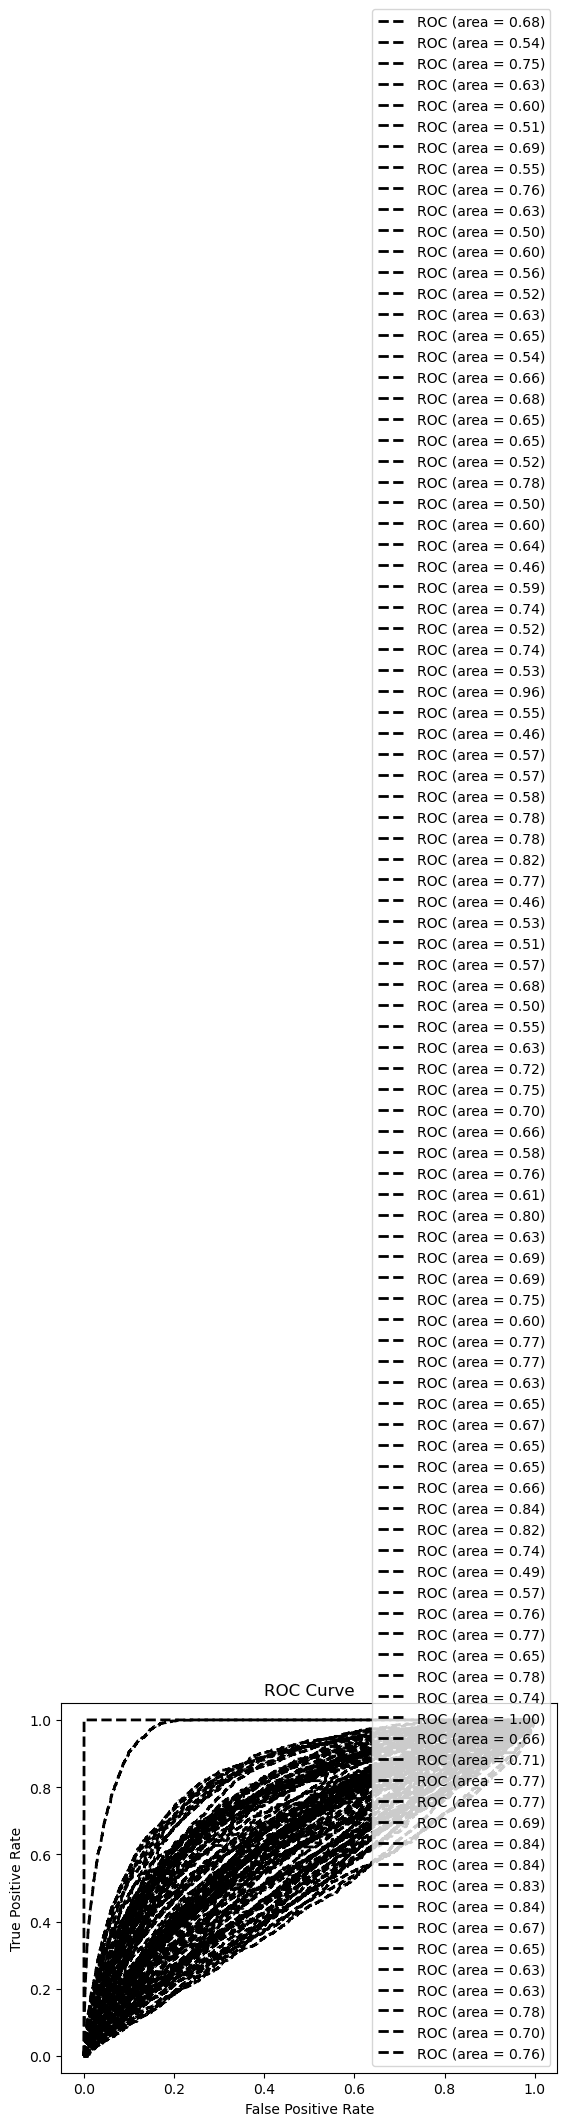

In [17]:
for r in regions:
    dir = 'model/P/'+r+'/'
    clf2 = joblib.load(dir+'model.pkl')

#     dir += 'result/'
#     if not os.path.exists(dir+'result/'):
#         os.makedirs(dir+'result/')
        
#     df_accuracy = df.DataFrame()
#     df_auc = df.DataFrame()
    arr_accuracy = []
    arr_auc = []
        
    for b in bacteria.keys():
        print(b, r)
        try:
            test_id_df, test_seq_df = readfasta('data/datasets/'+b+'/'+r+'/all.fasta')
            test_df = scan_pre(test_seq_df[0], r)
            test_df = fastaToHotEncodingSequences(test_df)
            y_pred_pro = clf2.predict_proba(test_df)[:, 1]
            df      = pd.DataFrame({"CHROM": [ s  for s in test_id_df[0] ], "SEQ": [ s  for s in test_seq_df[0] ], "PRED": y_pred_pro})
            # pred_file_path = os.path.join(out_dir, "sequences_predictions.csv")
            if not os.path.exists(dir+'result/'+b+"/"):
                os.makedirs(dir+'result/'+b+"/")
            # print_fn("\n\t PREDICTIONS GENERATED SUCCESSFULLY. SAMPLE: \n\n{}. \n\nSAVED AT {}".format( df.head(), pred_file_path ) , log_file)
            # print_fn("\n\t TIME ELAPSED FROM START (HOUR:MIN:SEC): {}".format( time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)) ) , log_file)
            df.to_csv(dir+'result/'+b+"/sequences_predictions.csv", index=None, sep='\t', columns=None)
            accuracy, _auc = performance(dir+'result/'+b+"/", bacteria[b])
            arr_accuracy.append([b, accuracy])
            arr_auc.append([b, _auc])
        except ValueError:
            print(b, r, 'failed.')
        
    df_accuracy = pd.DataFrame(arr_accuracy, columns=['name', 'accuracy'])
    df_auc = pd.DataFrame(arr_auc, columns=['name', 'auc'])
    
    df_accuracy.to_csv(dir+'/accuracy.csv')
    df_auc.to_csv(dir+'/auc.csv')
    

In [22]:
bacteria = {'Bacteroides thetaiotaomicron VPI-5482': 1616,
            'Campylobacter jejuni NCTC11168': 675,
            'Synechococcus elongatus UTEX 2973': 2429,
            'Synechocystis sp. PCC 6803': 170}

In [45]:
p_id_df, p_seq_df = readfasta('data/datasets/Bacillus subtilis 168/'+r+'/positive.fasta')
n_id_df, n_seq_df = readfasta('data/datasets/Bacillus subtilis 168/'+r+'/negative_new.fasta')
train_df = fastaToHotEncoding(p_seq_df, n_seq_df)

In [46]:
train_df

,A,G,C,T,A,G,C,T,A,G,...,T,A,G,C,T,A,G,C,T,label
0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
3,0,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18645,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
18646,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
18647,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
18648,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [47]:
class_weight = compute_class_weight(class_weight = 'balanced', 
                                    classes = np.unique(train_df['label']),
                                    y = train_df['label'])

In [48]:
x_train = train_df.iloc[:, :-1]
y_train = train_df[:]['label']

In [49]:
x_train

,A,G,C,T,A,G,C,T,A,G,...,C,T,A,G,C,T,A,G,C,T
0,0,0,0,1,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
3,0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18645,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
18646,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
18647,1,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
18648,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [50]:
class_weight = compute_class_weight(class_weight = 'balanced', 
                                        classes = np.unique(train_df['label']),
                                        y = train_df['label'])


In [51]:
class_weight

array([0.55, 5.5 ])

888 1626
299 19814
accuracy:  0.9149246475449684
AUROC:  0.9445441678507212


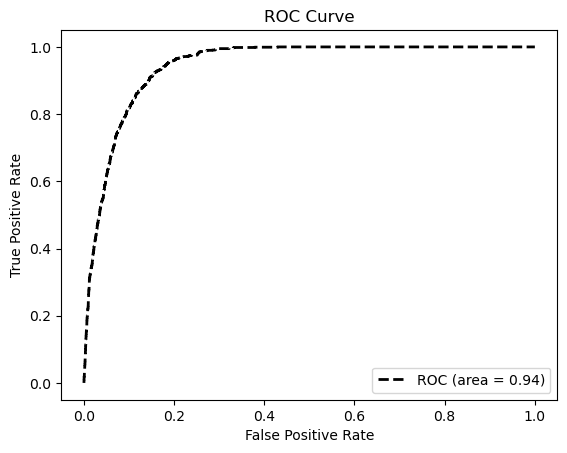

In [50]:

dir = 'model/test/random_new/'
clf2 = joblib.load(dir+'model.pkl')

arr_accuracy = []
arr_auc = []


# try:
test_id_df, test_seq_df = readfasta('data/datasets/test/random_new/L/all.fasta')
test_df = scan_pre(test_seq_df[0], r)
test_df = fastaToHotEncodingSequences(test_df)
y_pred_pro = clf2.predict_proba(test_df)[:, 1]
df      = pd.DataFrame({"CHROM": [ s  for s in test_id_df[0] ], "SEQ": [ s  for s in test_seq_df[0] ], "PRED": y_pred_pro})
# pred_file_path = os.path.join(out_dir, "sequences_predictions.csv")
#         if not os.path.exists(dir+'result/'+b+"/"):
#             os.makedirs(dir+'result/'+b+"/")
# print_fn("\n\t PREDICTIONS GENERATED SUCCESSFULLY. SAMPLE: \n\n{}. \n\nSAVED AT {}".format( df.head(), pred_file_path ) , log_file)
# print_fn("\n\t TIME ELAPSED FROM START (HOUR:MIN:SEC): {}".format( time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)) ) , log_file)
df.to_csv(dir+'sequences_predictions.csv', index=None, sep='\t', columns=None)
accuracy, _auc = performance(dir, 1187)
#         arr_accuracy.append([b, accuracy])
#         arr_auc.append([b, _auc])
# except ValueError:
#     print('failed.')

# df_accuracy = pd.DataFrame(arr_accuracy, columns=['name', 'accuracy'])
# df_auc = pd.DataFrame(arr_auc, columns=['name', 'auc'])

# df_accuracy.to_csv(dir+'/accuracy.csv')
# df_auc.to_csv(dir+'/auc.csv')

In [28]:
joblib.dump(clf, dir+'/model.pkl')

['model/test/40/model.pkl']

In [49]:
p_id_df, p_seq_df = readfasta('data/datasets/test/random_new/E/positive.fasta')
n_id_df, n_seq_df = readfasta('data/datasets/test/random_new/E/negative.fasta')
train_df = fastaToHotEncoding(p_seq_df, n_seq_df)

x_train = train_df.iloc[:, :-1]
y_train = train_df[:]['label']

class_weight = compute_class_weight(class_weight = 'balanced', 
                                    classes = np.unique(train_df['label']),
                                    y = train_df['label'])

clf=RandomForestClassifier(class_weight = dict(enumerate(class_weight)))
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

clf=RandomForestClassifier(class_weight = dict(enumerate(class_weight)))
clf.fit(x_train, y_train)

parameters = pd.DataFrame.from_dict(CV_rfc.best_params_, orient="index", columns = None)
print(parameters)

dir = 'model/test/random_new/'
if not os.path.exists(dir):
    os.makedirs(dir)

joblib.dump(CV_rfc, dir+'model.pkl')
parameters.to_csv(dir+'parameters.csv', header = None)
print("model done.")


                     0
max_features      sqrt
min_samples_leaf     5
n_estimators      1000
model done.


In [15]:
print("Joblib version used to save the model:", joblib.__version__)

Joblib version used to save the model: 1.2.0


In [ ]:
CV_rfc.best_params_

In [ ]:
parameters = pd.DataFrame.from_dict(CV_rfc.best_params_, orient="index", columns = None)
print(parameters)

In [ ]:
dir = 'model/'+'UP'+'/'
if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
joblib.dump(CV_rfc,dir+'model.pkl')
parameters.to_csv(dir+'parameters.csv', header = None)

In [ ]:
clf2 = joblib.load(dir+'model.pkl')

In [ ]:
dir = 'result/'
if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:

for b in bacteria.keys():
    print(b)
    test_id_df, test_seq_df = readfasta('data/datasets/'+b+'/'+r+'/all.fasta')
    test_df = scan_pre(test_seq_df[0], r)
    test_df = fastaToHotEncodingSequences(test_df)
    y_pred_pro = clf2.predict_proba(test_df)[:, 1]
    df      = pd.DataFrame({"CHROM": [ s  for s in test_id_df[0] ], "SEQ": [ s  for s in test_seq_df[0] ], "PRED": y_pred_pro})
    # pred_file_path = os.path.join(out_dir, "sequences_predictions.csv")
    if not os.path.exists(dir+b+"/"+r+"/"):
        os.makedirs(dir+b+"/"+r+"/")
    # print_fn("\n\t PREDICTIONS GENERATED SUCCESSFULLY. SAMPLE: \n\n{}. \n\nSAVED AT {}".format( df.head(), pred_file_path ) , log_file)
    # print_fn("\n\t TIME ELAPSED FROM START (HOUR:MIN:SEC): {}".format( time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)) ) , log_file)
    df.to_csv(dir+b+"/"+r+"/sequences_predictions.csv", index=None, sep='\t', columns=None)
    performance(dir+b+"/"+r, bacteria[b])

In [ ]:
test_seq_df

In [ ]:
test_df

In [ ]:
x_train

In [ ]:
clf2.predict(x_train)

In [ ]:
# test_id_df, test_seq_df = readfasta('Campylobacter jejuni NCTC11168/35+s+10/all.fasta')
# test_id_df, test_seq_df = readfasta('datasets/'+b+'/35+s+10/all.fasta')
test_id_df, test_seq_df = readfasta('test1.fasta')
# test_df = fastaToHotEncodingSequences(test_seq_df)

In [ ]:
test_seq_df

In [ ]:
test_df = scan_pre(test_seq_df[0])

In [ ]:
test_df

In [ ]:
test_df = fastaToHotEncodingSequences(test_df)

In [ ]:
y_pred = clf2.predict(test_df)
print(y_pred)

In [ ]:
y_pred_pro = clf2.predict_proba(test_df)[:, 1]
print(y_pred_pro)

In [ ]:
score(forest, x_train, y_train, x_test, y_test, train=False)